In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
from sklearn.model_selection import train_test_split

# 랜덤 시드 결정
seed_num = 11
np.random.seed(seed_num)
torch.manual_seed(seed_num) 

# 폴더에서 데이터 로드 
dataset = ImageFolder(root="../data/resnet_data")
dataset_indices = list(range(len(dataset)))

In [4]:
targets = dataset.targets

In [5]:
# 80 : 20 나누기
train_indices, val_test_indices = train_test_split(dataset_indices, test_size=0.2, stratify=targets, random_state=seed_num)

In [6]:
val_test_target = [targets[i] for i in val_test_indices]

In [7]:
# 20 -> 10: 10으로 분할하기
val_indices, test_indices = train_test_split(val_test_indices, test_size=0.5, stratify=val_test_target, random_state=seed_num)

In [8]:
# train_indices, val_indices, test_indices
# 최종 데이터셋 생성
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

In [9]:
class_idx = dataset.class_to_idx
class_idx

{'마동석': 0, '박보영': 1, '차은우': 2, '카리나': 3}

In [10]:
class_names = {}
for key, val in class_idx.items():
    class_names[val] = key

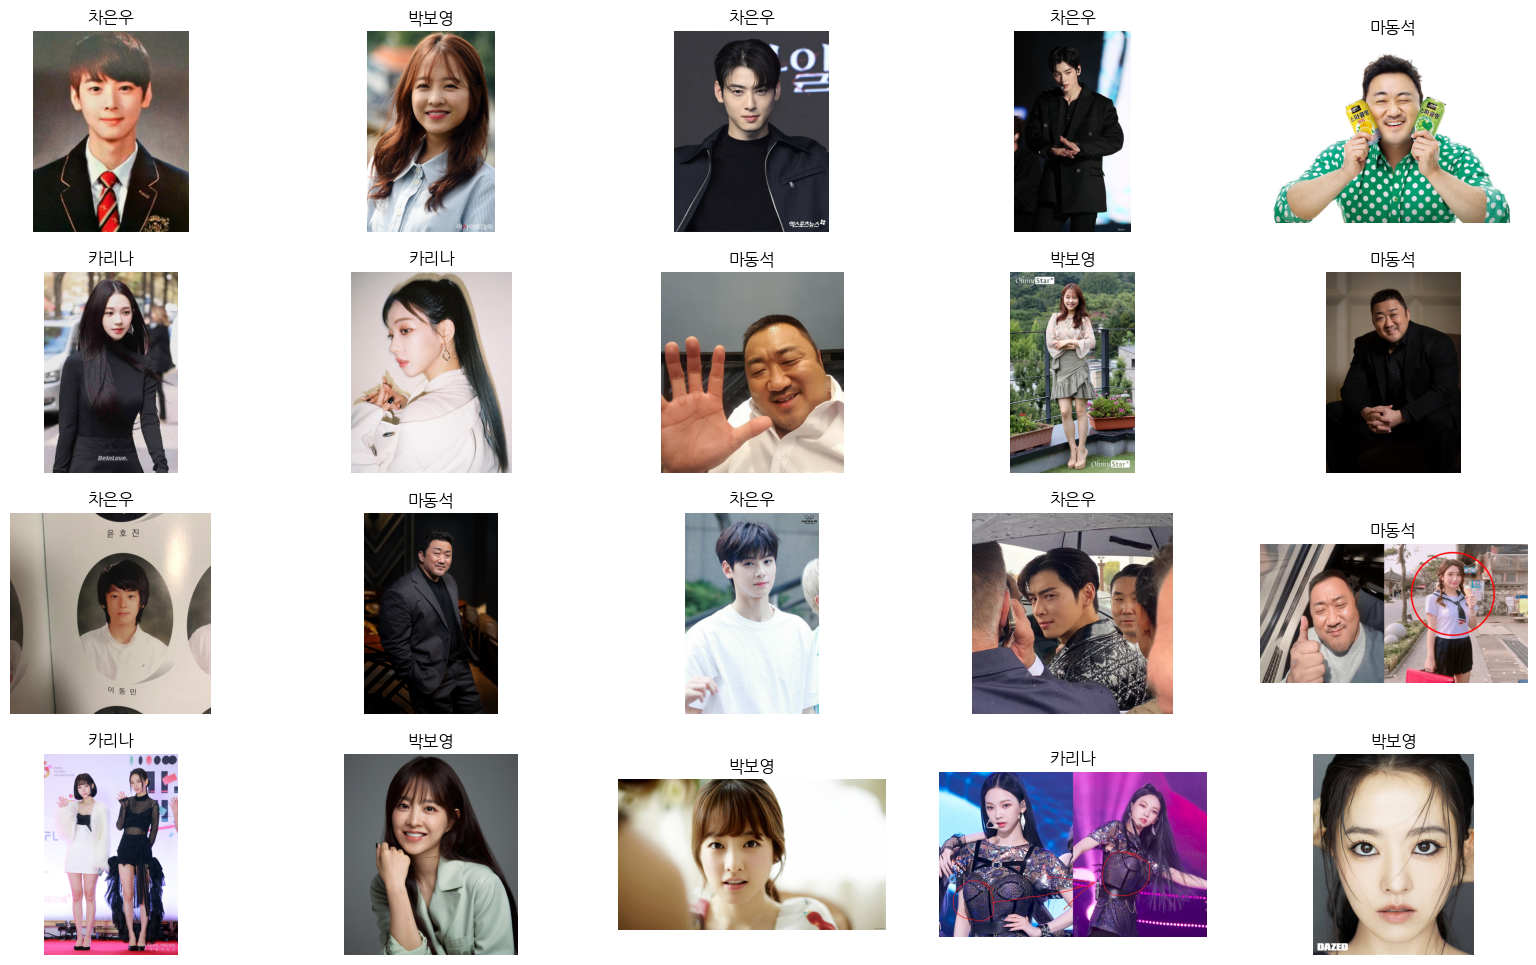

In [11]:
# 시각화 해보기
plt.figure(figsize=(20, 12))
for idx, item in enumerate(test_dataset, start=1):
    if idx > 20:  # 20개 이미지로 제한
        break
    plt.subplot(4, 5, idx)
    image = item[0]
    class_name = class_names[item[1]]
    plt.title(class_name)
    plt.axis("off")
    plt.imshow(image)
plt.show()

In [12]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
from PIL import Image
from torchvision.datasets import ImageFolder

class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            sample = self.loader(path)
            if self.transform is not None:
                sample = self.transform(sample)
            if self.target_transform is not None:
                target = self.target_transform(target)
            return sample, target
        except Exception as e:
            print(f"Error loading image {path}: {str(e)}")
            dummy_img = Image.new('RGB', (224, 224), color='black')
            if self.transform is not None:
                dummy_img = self.transform(dummy_img)
            return dummy_img, target

# 기존의 ImageFolder 대신 SafeImageFolder 사용
dataset = SafeImageFolder(root="../data/resnet_data")

In [14]:
import os
from PIL import Image

def check_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()
                except (IOError, SyntaxError) as e:
                    print(f'Bad file {file_path}: {e}')

check_images("../data/resnet_data")

In [15]:
# transform 설정
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# 데이터 로더 설정
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

### 모델 설정 - 사전 훈련된 가중치 가져오기

In [16]:
# 1. 사전 훈련된 가중치 가져오기
transfer_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [17]:
# 2. 모델의 모든 레이어를 고정하기
for param in transfer_model.parameters():
    param.requires_grad = False

In [18]:
# 3-1. 모델의 마지막 레이어(분류기) 교체하기
num_ftrs = transfer_model.fc.in_features # 마지막 분류 모델에 input 될 features 값
# 우리가 원하는 분류기 붙이기
# transfer_model.fc = nn.Linear(num_ftrs, 4)  # 4개의 출력 클래스(데이터에 맞는 클래스 갯수) 하나만 하는 경우

# 여러개로 하는 경우 
transfer_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024), # 512 -> 1024
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 4) # 256 - > 4
)

In [19]:
# 모델의 모든 레이어와 학습 가능 여부를 출력
for name, param in transfer_model.named_parameters():
    print(f'Layer: {name} | Requires_grad: {param.requires_grad}')

Layer: conv1.weight | Requires_grad: False
Layer: bn1.weight | Requires_grad: False
Layer: bn1.bias | Requires_grad: False
Layer: layer1.0.conv1.weight | Requires_grad: False
Layer: layer1.0.bn1.weight | Requires_grad: False
Layer: layer1.0.bn1.bias | Requires_grad: False
Layer: layer1.0.conv2.weight | Requires_grad: False
Layer: layer1.0.bn2.weight | Requires_grad: False
Layer: layer1.0.bn2.bias | Requires_grad: False
Layer: layer1.1.conv1.weight | Requires_grad: False
Layer: layer1.1.bn1.weight | Requires_grad: False
Layer: layer1.1.bn1.bias | Requires_grad: False
Layer: layer1.1.conv2.weight | Requires_grad: False
Layer: layer1.1.bn2.weight | Requires_grad: False
Layer: layer1.1.bn2.bias | Requires_grad: False
Layer: layer2.0.conv1.weight | Requires_grad: False
Layer: layer2.0.bn1.weight | Requires_grad: False
Layer: layer2.0.bn1.bias | Requires_grad: False
Layer: layer2.0.conv2.weight | Requires_grad: False
Layer: layer2.0.bn2.weight | Requires_grad: False
Layer: layer2.0.bn2.bias 

### 모델구조 확인해보기

In [20]:
device = torch.device("cuda")
transfer_model = transfer_model.to(device)

In [21]:
from torchsummary import summary
summary(transfer_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [22]:
for param in transfer_model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True


In [23]:
# 손실 함수 및 최적화 알고리즘 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transfer_model.parameters(), lr=1e-4)

In [24]:
from tqdm import tqdm
import torchmetrics
# train 및 best 모델 저장 함수
def train_and_validate_best(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses = []
    val_losses = []
    accuracies = []
    
    min_val_loss = float('inf')  # 가장 좋은 모델을 추적하기 위한 변수 초기화
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # 검증 과정
        model.eval()
        running_val_loss = 0.0
        accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=4, average='macro').to(device)

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                accuracy_metric.update(outputs, labels)
            accuracy = accuracy_metric.compute()  # 정확도 계산
            accuracies.append(accuracy.item())
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch [{epoch + 1}/{epochs}] - Training loss: {epoch_loss:.3f}, Validation loss: {epoch_val_loss:.3f}, accuracy : {accuracy:.2%}')
        
        # 가장 좋은 모델만 저장
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'best 모델 저장 {epoch}.')
    
    return train_losses, val_losses, accuracies

In [25]:
# 최종 학습
history = train_and_validate_best(transfer_model, train_loader, val_loader, optimizer, criterion, epochs=50)

100%|██████████| 21/21 [00:09<00:00,  2.30it/s]


Epoch [1/50] - Training loss: 1.340, Validation loss: 1.237, accuracy : 48.86%
best 모델 저장 0.


100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


Epoch [2/50] - Training loss: 1.152, Validation loss: 1.063, accuracy : 65.91%
best 모델 저장 1.


100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch [3/50] - Training loss: 1.000, Validation loss: 0.944, accuracy : 73.86%
best 모델 저장 2.


100%|██████████| 21/21 [00:09<00:00,  2.23it/s]


Epoch [4/50] - Training loss: 0.874, Validation loss: 0.833, accuracy : 82.73%
best 모델 저장 3.


100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch [5/50] - Training loss: 0.806, Validation loss: 0.753, accuracy : 80.68%
best 모델 저장 4.


100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch [6/50] - Training loss: 0.740, Validation loss: 0.684, accuracy : 83.18%
best 모델 저장 5.


100%|██████████| 21/21 [00:09<00:00,  2.26it/s]


Epoch [7/50] - Training loss: 0.663, Validation loss: 0.627, accuracy : 90.00%
best 모델 저장 6.


100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Epoch [8/50] - Training loss: 0.633, Validation loss: 0.578, accuracy : 83.18%
best 모델 저장 7.


100%|██████████| 21/21 [00:09<00:00,  2.28it/s]


Epoch [9/50] - Training loss: 0.528, Validation loss: 0.519, accuracy : 85.68%
best 모델 저장 8.


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch [10/50] - Training loss: 0.533, Validation loss: 0.484, accuracy : 92.50%
best 모델 저장 9.


100%|██████████| 21/21 [00:09<00:00,  2.26it/s]


Epoch [11/50] - Training loss: 0.482, Validation loss: 0.461, accuracy : 90.00%
best 모델 저장 10.


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch [12/50] - Training loss: 0.487, Validation loss: 0.441, accuracy : 92.73%
best 모델 저장 11.


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


Epoch [13/50] - Training loss: 0.428, Validation loss: 0.401, accuracy : 90.00%
best 모델 저장 12.


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch [14/50] - Training loss: 0.438, Validation loss: 0.392, accuracy : 92.50%
best 모델 저장 13.


100%|██████████| 21/21 [00:09<00:00,  2.23it/s]


Epoch [15/50] - Training loss: 0.401, Validation loss: 0.383, accuracy : 92.73%
best 모델 저장 14.


100%|██████████| 21/21 [00:09<00:00,  2.26it/s]


Epoch [16/50] - Training loss: 0.344, Validation loss: 0.357, accuracy : 90.00%
best 모델 저장 15.


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


Epoch [17/50] - Training loss: 0.337, Validation loss: 0.332, accuracy : 92.50%
best 모델 저장 16.


100%|██████████| 21/21 [00:09<00:00,  2.28it/s]


Epoch [18/50] - Training loss: 0.339, Validation loss: 0.334, accuracy : 95.00%


100%|██████████| 21/21 [00:09<00:00,  2.23it/s]


Epoch [19/50] - Training loss: 0.335, Validation loss: 0.314, accuracy : 95.00%
best 모델 저장 18.


100%|██████████| 21/21 [00:09<00:00,  2.27it/s]


Epoch [20/50] - Training loss: 0.293, Validation loss: 0.298, accuracy : 92.50%
best 모델 저장 19.


100%|██████████| 21/21 [00:09<00:00,  2.30it/s]


Epoch [21/50] - Training loss: 0.293, Validation loss: 0.290, accuracy : 95.00%
best 모델 저장 20.


100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


Epoch [22/50] - Training loss: 0.324, Validation loss: 0.309, accuracy : 92.73%


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


Epoch [23/50] - Training loss: 0.361, Validation loss: 0.298, accuracy : 90.23%


100%|██████████| 21/21 [00:09<00:00,  2.28it/s]


Epoch [24/50] - Training loss: 0.340, Validation loss: 0.275, accuracy : 92.50%
best 모델 저장 23.


100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch [25/50] - Training loss: 0.292, Validation loss: 0.265, accuracy : 92.50%
best 모델 저장 24.


100%|██████████| 21/21 [00:09<00:00,  2.28it/s]


Epoch [26/50] - Training loss: 0.226, Validation loss: 0.275, accuracy : 95.00%


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch [27/50] - Training loss: 0.230, Validation loss: 0.257, accuracy : 92.50%
best 모델 저장 26.


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch [28/50] - Training loss: 0.226, Validation loss: 0.280, accuracy : 87.73%


100%|██████████| 21/21 [00:09<00:00,  2.32it/s]


Epoch [29/50] - Training loss: 0.250, Validation loss: 0.275, accuracy : 92.73%


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch [30/50] - Training loss: 0.206, Validation loss: 0.235, accuracy : 95.00%
best 모델 저장 29.


100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


Epoch [31/50] - Training loss: 0.228, Validation loss: 0.241, accuracy : 92.50%


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


Epoch [32/50] - Training loss: 0.204, Validation loss: 0.238, accuracy : 92.50%


100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Epoch [33/50] - Training loss: 0.218, Validation loss: 0.226, accuracy : 92.50%
best 모델 저장 32.


100%|██████████| 21/21 [00:09<00:00,  2.23it/s]


Epoch [34/50] - Training loss: 0.196, Validation loss: 0.212, accuracy : 92.50%
best 모델 저장 33.


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch [35/50] - Training loss: 0.175, Validation loss: 0.243, accuracy : 95.00%


100%|██████████| 21/21 [00:09<00:00,  2.23it/s]


Epoch [36/50] - Training loss: 0.168, Validation loss: 0.216, accuracy : 92.50%


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch [37/50] - Training loss: 0.146, Validation loss: 0.218, accuracy : 95.00%


100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Epoch [38/50] - Training loss: 0.153, Validation loss: 0.203, accuracy : 92.50%
best 모델 저장 37.


100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch [39/50] - Training loss: 0.176, Validation loss: 0.197, accuracy : 95.00%
best 모델 저장 38.


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch [40/50] - Training loss: 0.175, Validation loss: 0.203, accuracy : 92.50%


100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch [41/50] - Training loss: 0.192, Validation loss: 0.250, accuracy : 87.73%


100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Epoch [42/50] - Training loss: 0.166, Validation loss: 0.195, accuracy : 92.50%
best 모델 저장 41.


100%|██████████| 21/21 [00:09<00:00,  2.23it/s]


Epoch [43/50] - Training loss: 0.157, Validation loss: 0.184, accuracy : 92.50%
best 모델 저장 42.


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


Epoch [44/50] - Training loss: 0.154, Validation loss: 0.198, accuracy : 95.00%


100%|██████████| 21/21 [00:09<00:00,  2.26it/s]


Epoch [45/50] - Training loss: 0.120, Validation loss: 0.216, accuracy : 87.50%


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch [46/50] - Training loss: 0.151, Validation loss: 0.210, accuracy : 87.50%


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch [47/50] - Training loss: 0.144, Validation loss: 0.182, accuracy : 95.00%
best 모델 저장 46.


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch [48/50] - Training loss: 0.130, Validation loss: 0.199, accuracy : 92.50%


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


Epoch [49/50] - Training loss: 0.124, Validation loss: 0.191, accuracy : 92.50%


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


Epoch [50/50] - Training loss: 0.135, Validation loss: 0.181, accuracy : 95.00%
best 모델 저장 49.


### 저장된 모델 불러오기

In [29]:
# 백본
transfer_model_best = models.resnet18(weights=None)
num_ftrs = transfer_model_best.fc.in_features

# 여러개로 하는 경우 
transfer_model_best.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024), # 512 -> 1024
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 4) # 256 - > 4
)

transfer_model_best.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [31]:
from PIL import Image
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 모델 테스트 해보기
image = Image.open("강호동.jpg")
input_image = test_transform(image)
input_image.shape

torch.Size([3, 224, 224])

In [32]:
input_image = input_image.unsqueeze(0)
input_image

tensor([[[[-1.2959, -1.2788, -1.2788,  ..., -1.3473, -1.3644, -1.3644],
          [-1.2788, -1.2617, -1.2617,  ..., -1.3302, -1.3302, -1.3473],
          [-1.2617, -1.2445, -1.2445,  ..., -1.2959, -1.3302, -1.3302],
          ...,
          [-1.3302, -1.3473, -1.3473,  ..., -0.9534, -1.7240, -1.7754],
          [-1.3644, -1.3302, -1.3302,  ..., -1.8097, -1.7925, -1.8268],
          [-1.3987, -1.3815, -1.3644,  ..., -1.8610, -1.7754, -1.8097]],

         [[-1.1954, -1.1954, -1.2129,  ..., -1.2129, -1.2129, -1.2129],
          [-1.1954, -1.1779, -1.1954,  ..., -1.1954, -1.1779, -1.1954],
          [-1.1954, -1.1779, -1.1779,  ..., -1.1779, -1.1779, -1.1779],
          ...,
          [-1.0378, -1.0553, -1.0553,  ..., -0.7227, -1.4405, -1.4755],
          [-1.0553, -1.0203, -1.0203,  ..., -1.5455, -1.4930, -1.5455],
          [-1.0728, -1.0553, -1.0203,  ..., -1.5630, -1.4930, -1.5280]],

         [[-0.3404, -0.3404, -0.3404,  ..., -0.3404, -0.3753, -0.3753],
          [-0.3404, -0.3230, -

In [33]:
device = torch.device('cuda')

In [34]:
input_image = input_image.to(device) # GPU 데이터 넣기

In [35]:
transfer_model_best.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
with torch.no_grad():
    transfer_model_best.eval()
    outputs = transfer_model_best(input_image)
    _, preds = torch.max(outputs, 1)

    print("모델 예측 결과 :", preds)
    print("모델 예측 결과 : ", class_names[preds.item()])

모델 예측 결과 : tensor([2], device='cuda:0')
모델 예측 결과 :  차은우


In [37]:
# 이미지 불러오는 함수
def load_img(image_path):
    
    test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path)
    image = test_transform(image).unsqueeze(0)

    return image

In [38]:
with torch.no_grad():
    transfer_model_best.eval()
    input_image = load_img("하니.jpg").to(device)
    outputs = transfer_model_best(input_image)
    _, preds = torch.max(outputs, 1)

    print("모델 예측 결과 :", preds)
    print("모델 예측 결과 : ", class_names[preds.item()])

모델 예측 결과 : tensor([3], device='cuda:0')
모델 예측 결과 :  카리나


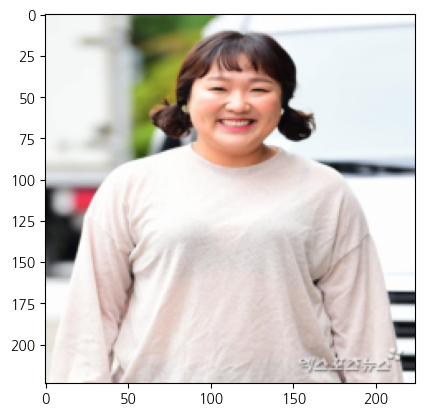

모델 예측 결과 : tensor([2], device='cuda:0')
모델 예측 결과 :  차은우


In [40]:
with torch.no_grad():
    transfer_model_best.eval()
    input_image = load_img("이수지.jpg").to(device)
    outputs = transfer_model_best(input_image)
    _, preds = torch.max(outputs, 1)

    original_img = input_image.squeeze(0).cpu().detach().numpy().transpose((1,2,0))
    
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])

    original_img = std * original_img + mean
    original_img = np.clip(original_img, 0, 1)
    
    plt.imshow(original_img)
    plt.show()
    print("모델 예측 결과 :", preds)
    print("모델 예측 결과 : ", class_names[preds.item()])

In [41]:
input_image = input_image.squeeze(0)
input_image.shape

torch.Size([3, 224, 224])

In [42]:
input_image = input_image.cpu().detach().numpy().transpose((1,2,0))

### 레이어별 특성맵 확인 및 시각화

In [43]:
transfer_model_best

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
for a, b in transfer_model_best.named_modules():
    if isinstance(b, torch.nn.Conv2d):
        print(a)


conv1
layer1.0.conv1
layer1.0.conv2
layer1.1.conv1
layer1.1.conv2
layer2.0.conv1
layer2.0.conv2
layer2.0.downsample.0
layer2.1.conv1
layer2.1.conv2
layer3.0.conv1
layer3.0.conv2
layer3.0.downsample.0
layer3.1.conv1
layer3.1.conv2
layer4.0.conv1
layer4.0.conv2
layer4.0.downsample.0
layer4.1.conv1
layer4.1.conv2


In [45]:
transfer_model_best

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
# 후크 등록 -> 이미지가 모델을 통과할 때, 어떻게 변화하는지 확인하기 위해 추적 달아놓는 것
input_image = load_img("하니.jpg").to(device)

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

hooks = []

# 모든 basicBlock 에 대해서 후크 등록
for name, module in transfer_model_best.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        handle = module.register_forward_hook(get_activation(name))
        hooks.append((name, handle))

In [47]:
# 모델을 통해 이미지 전달
with torch.no_grad():

    _ = transfer_model_best(input_image)

(112, 112)


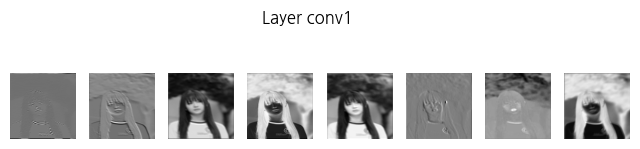

(56, 56)


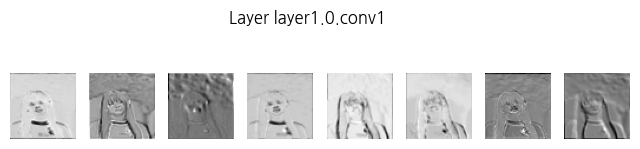

(56, 56)


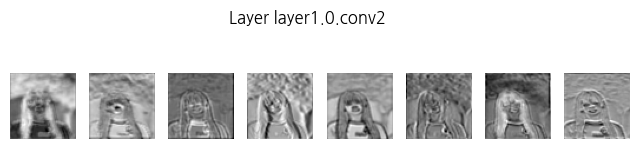

(56, 56)


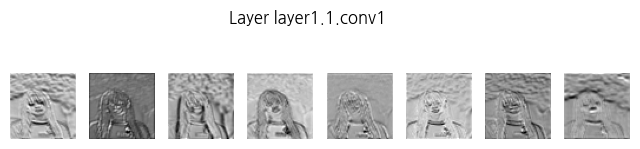

(56, 56)


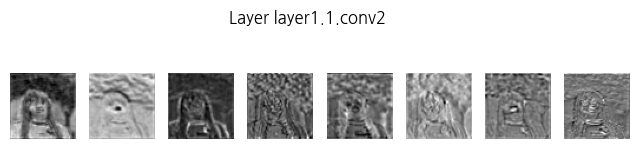

(28, 28)


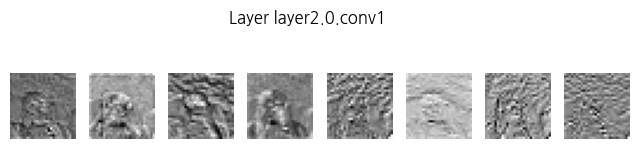

(28, 28)


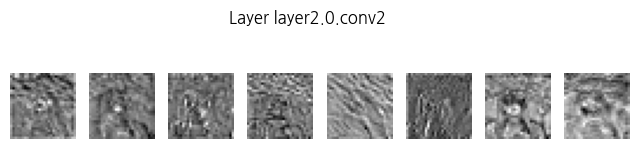

(28, 28)


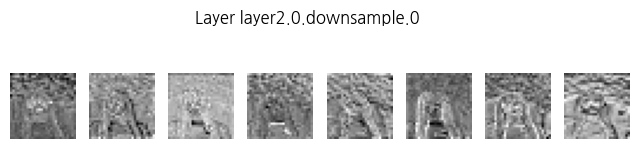

(28, 28)


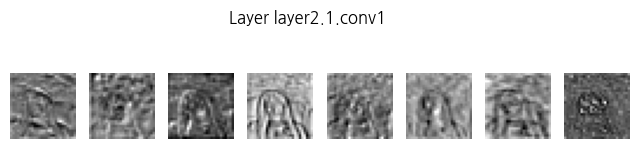

(28, 28)


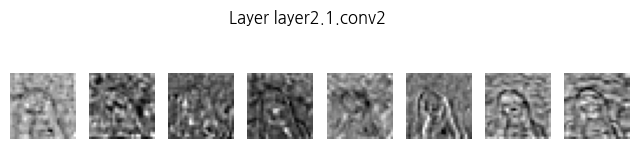

(14, 14)


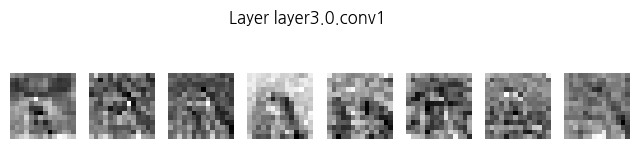

(14, 14)


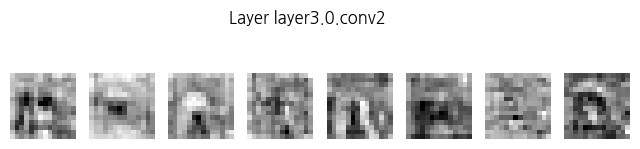

(14, 14)


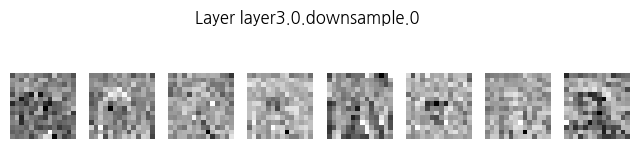

(14, 14)


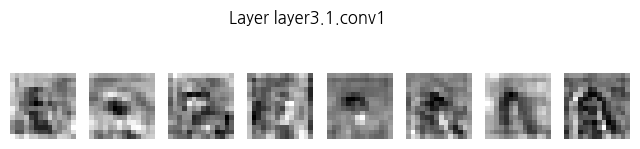

(14, 14)


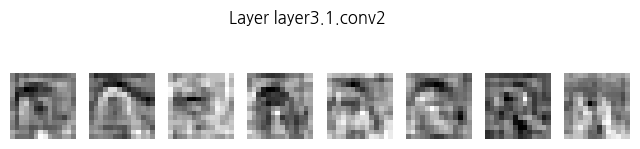

(7, 7)


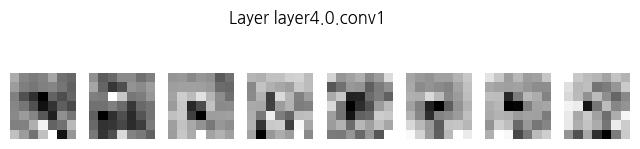

(7, 7)


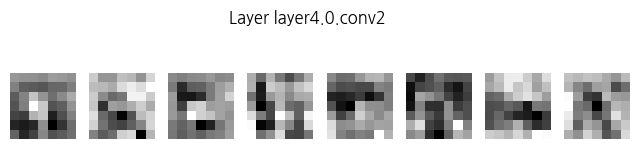

(7, 7)


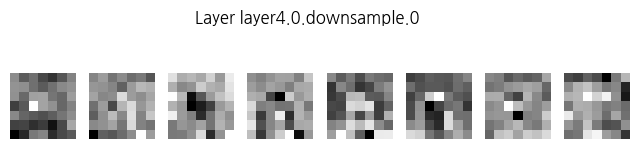

(7, 7)


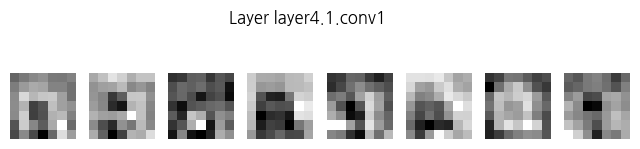

(7, 7)


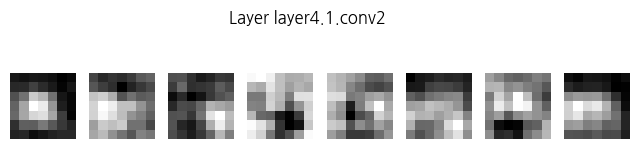

In [48]:
# 후크에 담긴 이미지를 시각화
for name, act in activation.items():
    img_size = act[0][0].cpu().numpy().shape
    print(img_size)
    plt.figure(figsize=(8,2))
    for i in range(8):
        plt.subplot(1, 8, i+1)
        img_array = act[0][i].cpu().numpy()
        plt.imshow(img_array, cmap='gray')
        plt.axis("off")
    plt.suptitle(f"Layer {name} ")
    plt.show()

### 특정 레이어를 고정하는 방법

In [49]:
transfer_model_frozen = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 모든 파라미터를 고정
for param in transfer_model_frozen.parameters():
    param.requires_grad = False

In [50]:
for name, child in transfer_model_frozen.named_children():
    if name in ['layer4', 'fc']:
        for param in child.parameters():
            param.requires_grad = True

In [51]:
# 실제 바뀌었는지 확인해보기
for name, param in transfer_model_frozen.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

In [52]:
### Xai - 설명가능한 딥러닝 
# !pip install grad-cam

In [55]:
### Xai 사용해보기
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus,AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image

In [56]:
model_grad_cam = transfer_model_best
model_grad_cam.to(device)
model_grad_cam.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
model_grad_cam.layer4[-1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [58]:
# tensor 이미지를 numpy 이미지로 변환하는 함수
def tensor_to_img(img_tensor):
    img = img_tensor.cpu().detach().numpy().transpose((1,2,0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

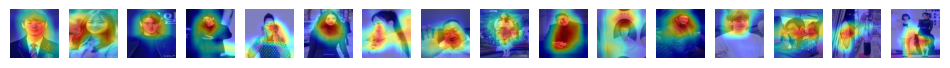

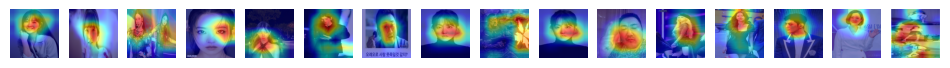

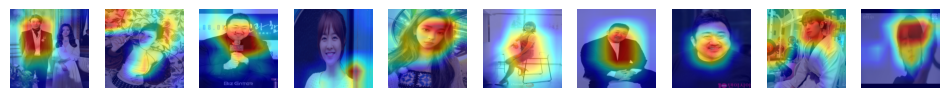

In [59]:
target_layers = [model_grad_cam.layer4[-1]] # 마지막 레이어를 타겟으로

cam = GradCAM(model=model_grad_cam, target_layers=target_layers)

for inputs, labels in test_loader:
    inputs = inputs.to(device)

    # 시각화 해보기
    plt.figure(figsize=(12, 3))
    for idx, image in enumerate(inputs, start=1):
        input_image = image.unsqueeze(0)
        grayscale_cam = cam(input_tensor=input_image, targets=None)[0]
        original_image = tensor_to_img(image)
        cam_image = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)

        plt.subplot(1, len(inputs), idx)
        plt.imshow(cam_image)
        plt.axis('off')
    plt.show()


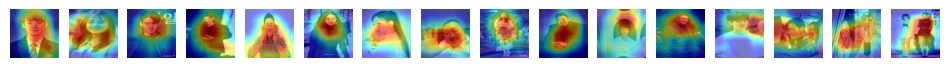

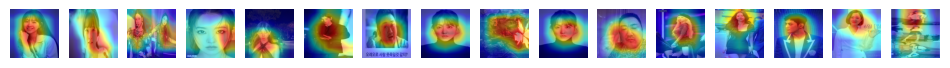

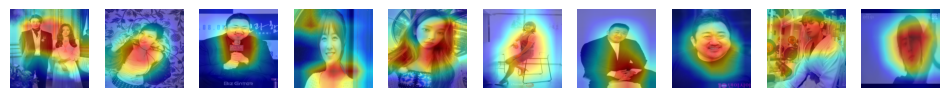

In [60]:
target_layers = [model_grad_cam.layer4[-1]] # 마지막 레이어를 타겟으로

cam = GradCAMPlusPlus(model=model_grad_cam, target_layers=target_layers)

for inputs, labels in test_loader:
    inputs = inputs.to(device)

    # 시각화 해보기
    plt.figure(figsize=(12, 3))
    for idx, image in enumerate(inputs, start=1):
        input_image = image.unsqueeze(0)
        grayscale_cam = cam(input_tensor=input_image, targets=None)[0]
        original_image = tensor_to_img(image)
        cam_image = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)

        plt.subplot(1, len(inputs), idx)
        plt.imshow(cam_image)
        plt.axis('off')
    plt.show()
